In [2]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.feature_selection import *
import seaborn as sns
from scipy import stats
import warnings
from numpy import median
from matplotlib.pyplot import cm
warnings.filterwarnings('ignore')

In [10]:
def regPlots(df,x,y,col,row,ylim=None,color='#ff7f03',fsize=[14,3],xlim=None,yerrd=np.array([None,None]),logscale=None):
    plt.figure(figsize=fsize)
    c = 1
    row_ls = list(set(df[row]))
    col_ls = sorted(list(set(df[col])))
    nRow = len(row_ls)
    nCol = len(col_ls)
    for i in range(nRow):
        for j in range(nCol):
            ax = plt.subplot(nRow,nCol,c)
            d = df.loc[(df[col]==col_ls[j])&(df[row]==row_ls[i])]
            #sns.regplot(x=x,y=y,data=d,ci=None,color=color,scatter_kws={'facecolors':d['color'],'edgecolors':d['color']},fit_reg=False) #blue '#1f77b4'
            #for cc in set(d.color):
            #    plt.plot(d.loc[d.color==cc][x],d.loc[d.color==cc][y],marker='.',linestyle='-',color=cc)
            axs = sns.lineplot(data=d, x=x, y=y, hue="topology", markers=["o","*",">","<","."], ci=None, style='topology', dashes=False)
            axs.get_legend().remove()
            
            if all(yerrd != None):
                yerr = []
                x_e = []
                y_e = []
                width_error = 0
                for tpl in d["topology"]:
                    for k in set(d[x]):
                        yerr.append(yerrd.loc[(yerrd[col]==col_ls[j])&(yerrd[row]==row_ls[i])&(yerrd[x]==k)&(yerrd.topology==tpl)][y].std())
                        x_e.append(d.loc[(d[x]==k)&(d.topology==tpl)][x].mean()+width_error)
                        y_e.append(d.loc[(d[x]==k)&(d.topology==tpl)][y].mean())
                        #width_error += 0.001
                    ax.errorbar(x_e, y_e, yerr=yerr, fmt='none', capsize=5, zorder=1, color='grey')
                    
            #plt.legend(bbox_to_anchor=(1.1,0.5,1,0.5), loc=2, borderaxespad=0.)
            if ylim != None:
                plt.ylim(ylim)
            else:
                plt.ylim(bottom=0)
            if xlim != None:
                plt.xlim(xlim)
            c += 1
            plt.title(col_ls[j])
            if logscale == True:
                plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.1,0.5,1,0.5), loc=2, borderaxespad=0.) 
    plt.xlabel(x)
    plt.ylabel(y)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    plt.show()

In [11]:
tpl25 = pd.read_table("WL7-4_result_d05/topology_N25_dg",delimiter=' ')
tpl50 = pd.read_table("WL7-4_result_d05/topology_N50_dg",delimiter=' ')
tpl100 = pd.read_table("WL7-4_result_d05/topology_N100_dg",delimiter=' ')
tpl500 = pd.read_table("WL7-4_result_d05/topology_N500_dg",delimiter=' ')
tpl750 = pd.read_table("WL7-4_result_d05/topology_N750_dg",delimiter=' ')

### Parameters explored in this notebook: the widest range of dispersal rates, delta=0.01, rho_fluc=0.5, h=5

### Full model with asymmetric interaction matrix. wide range of dispersal rates

<IPython.core.display.Javascript object>


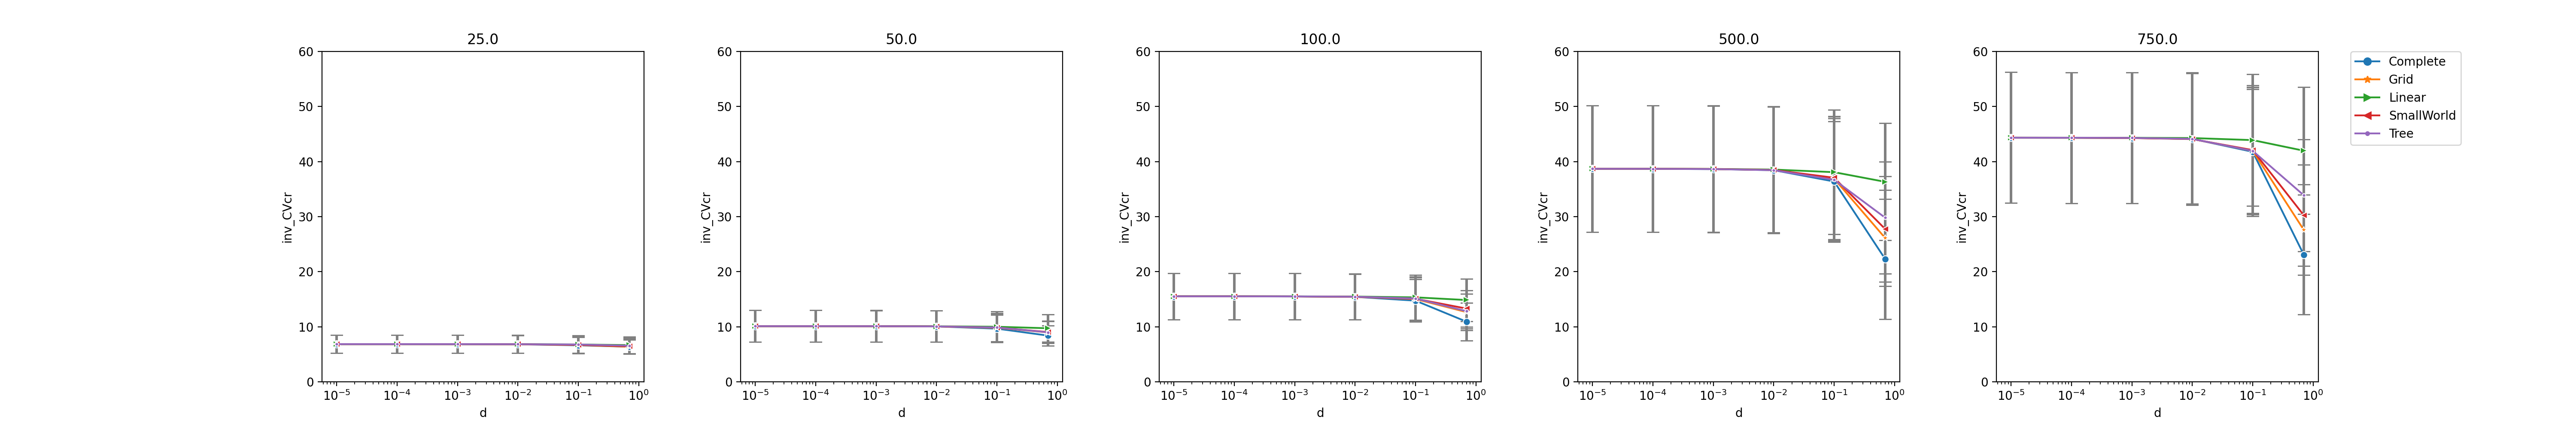

In [12]:
#rho_hetero=0.8, rho_fluc=0.95, std=1, r=2, delta=0.001, h=1, C=asymmetric
df25 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N25e25_h1_asymmetric_seed0_r2_delta0.001.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N50e50_h1_asymmetric_seed0_r2_delta0.001.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N100e100_h1_asymmetric_seed0_r2_delta0.001.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N500e500_h1_asymmetric_seed0_r2_delta0.001.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N750e750_h1_asymmetric_seed0_r2_delta0.001.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

dfall["inv_CVcr"] = 1 / dfall["CVcr"]

df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)]
regPlots(df,"d","inv_CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=[0,60],fsize=[30,5],logscale=True)
# Figure 2a (N=25) and 2b (N=750)

<IPython.core.display.Javascript object>


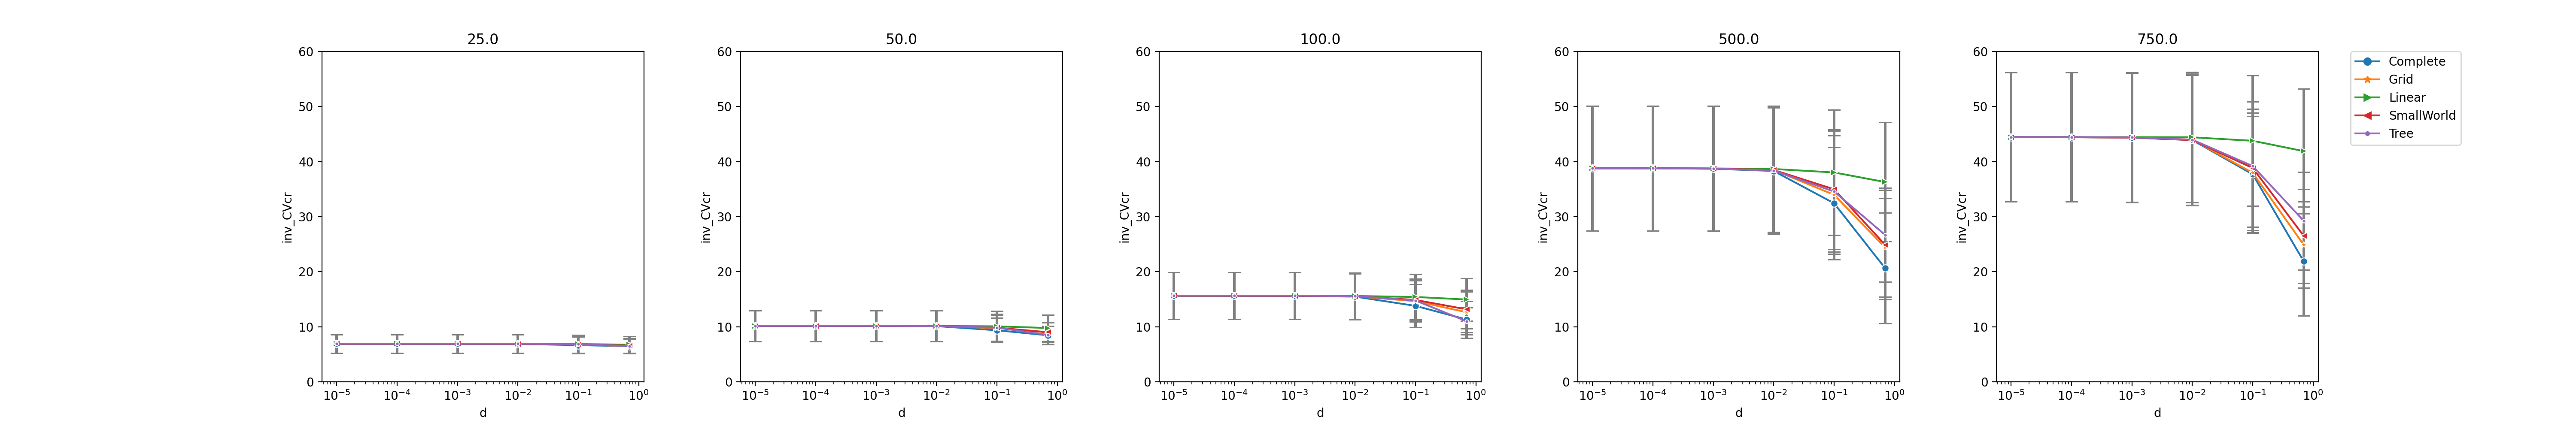

In [13]:
#rho_hetero=0.8, rho_fluc=0.95, std=1, r=0.7, delta=0.001, h=1, C=asymmetric
df25 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N25e25_h1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N50e50_h1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N100e100_h1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N500e500_h1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N750e750_h1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

dfall["inv_CVcr"] = 1 / dfall["CVcr"]

df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)]
regPlots(df,"d","inv_CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=[0,60],fsize=[30,5],logscale=True)
# Figure 2a (N=25) and 2b (N=750)

### Figure A2 (4th row, r=2)

<IPython.core.display.Javascript object>


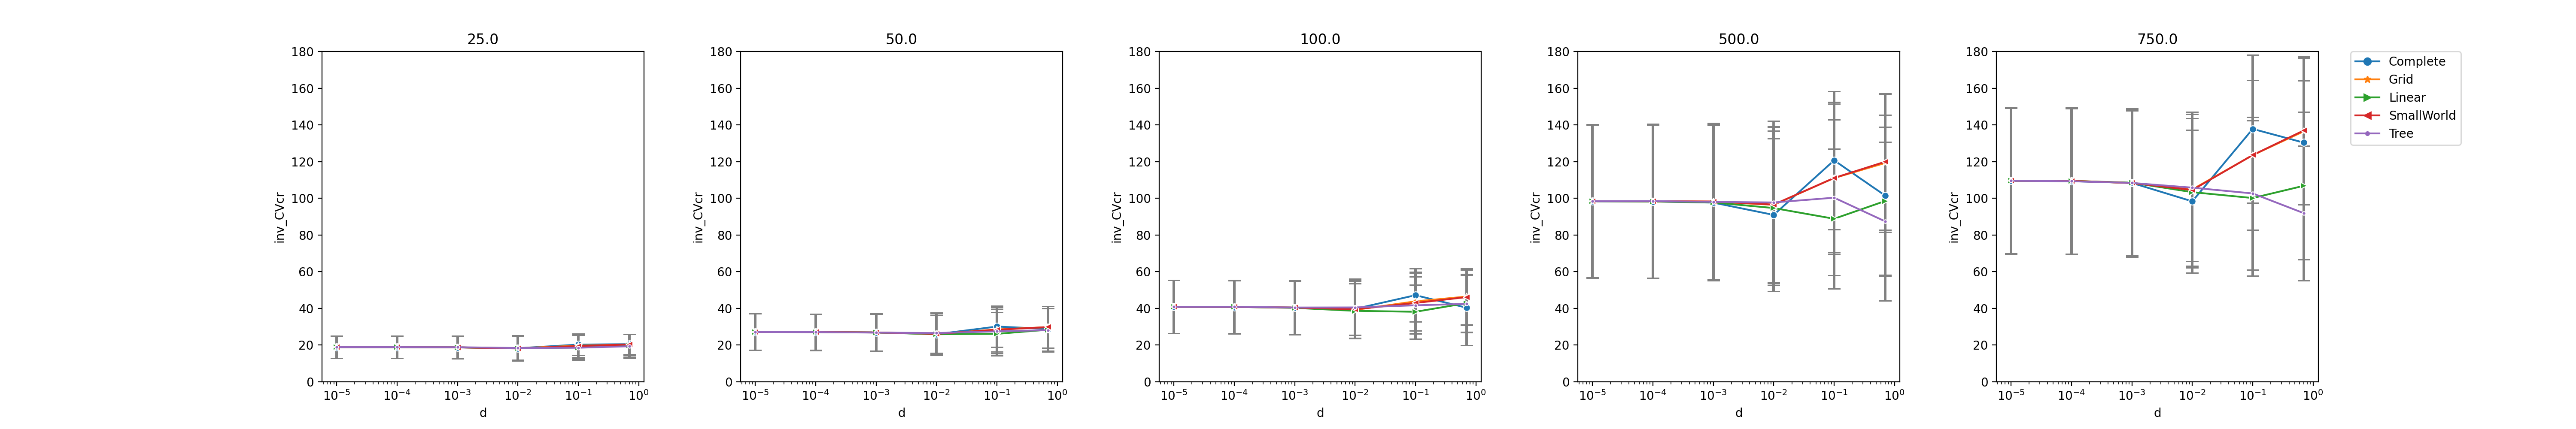

In [14]:
# rho_hetero=0.8, rho_fluc=0.95, std=1, r=2, delta=0.001, h=5, C=asymmetric
df25 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N25e25_h5_asymmetric_seed0_r2_delta0.001.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N50e50_h5_asymmetric_seed0_r2_delta0.001.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N100e100_h5_asymmetric_seed0_r2_delta0.001.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N500e500_h5_asymmetric_seed0_r2_delta0.001.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N750e750_h5_asymmetric_seed0_r2_delta0.001.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

dfall["inv_CVcr"] = 1 / dfall["CVcr"]

df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)]
regPlots(df,"d","inv_CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=[0,180],fsize=[30,5],logscale=True)

### Figure A1 (2nd row, r=2)

<IPython.core.display.Javascript object>


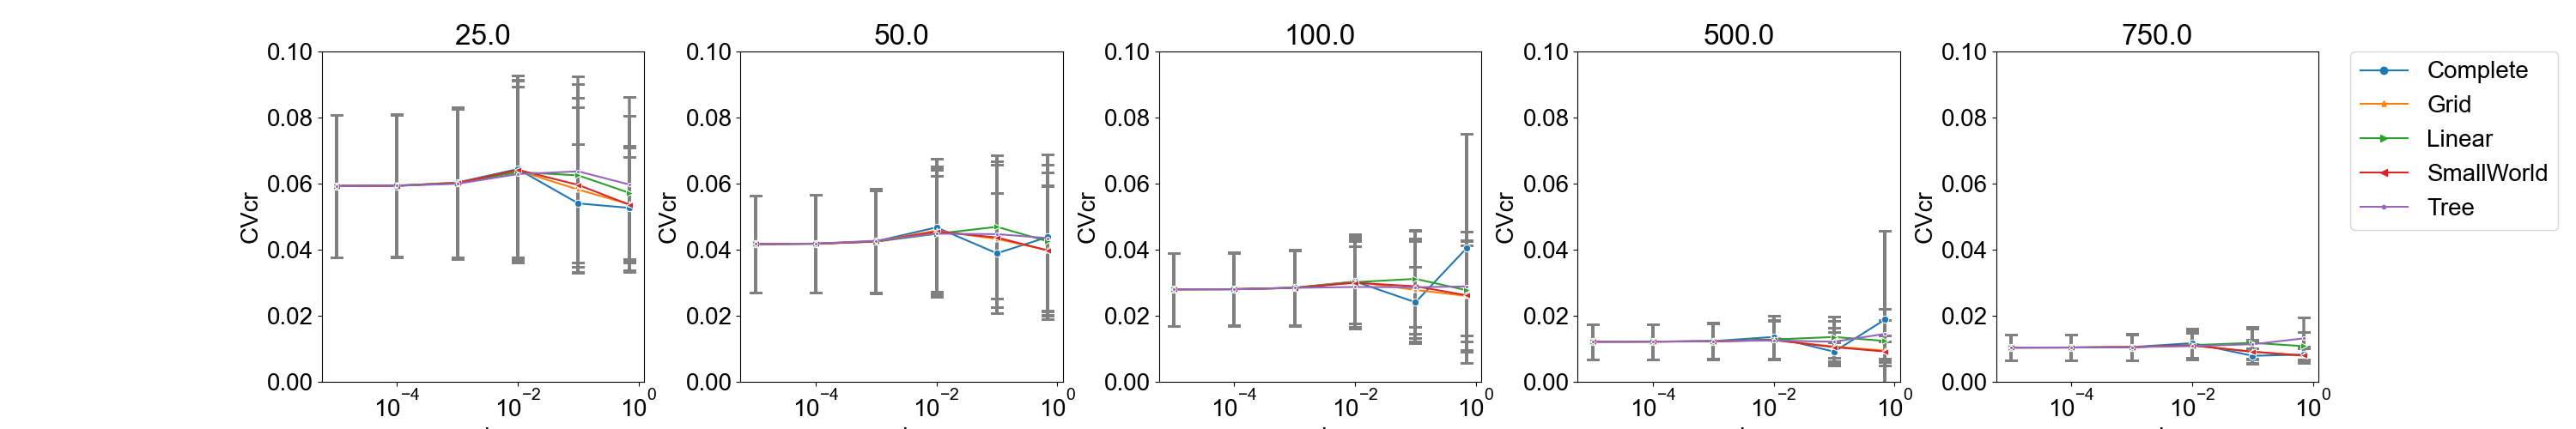

In [22]:
plt.rcParams.update({'font.size':20,'font.family':'arial'})
df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)]
regPlots(df,"d","CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=[0,0.1],fsize=[30,5],logscale=True)

### Figure A2 (3rd row, r=0.7)

<IPython.core.display.Javascript object>


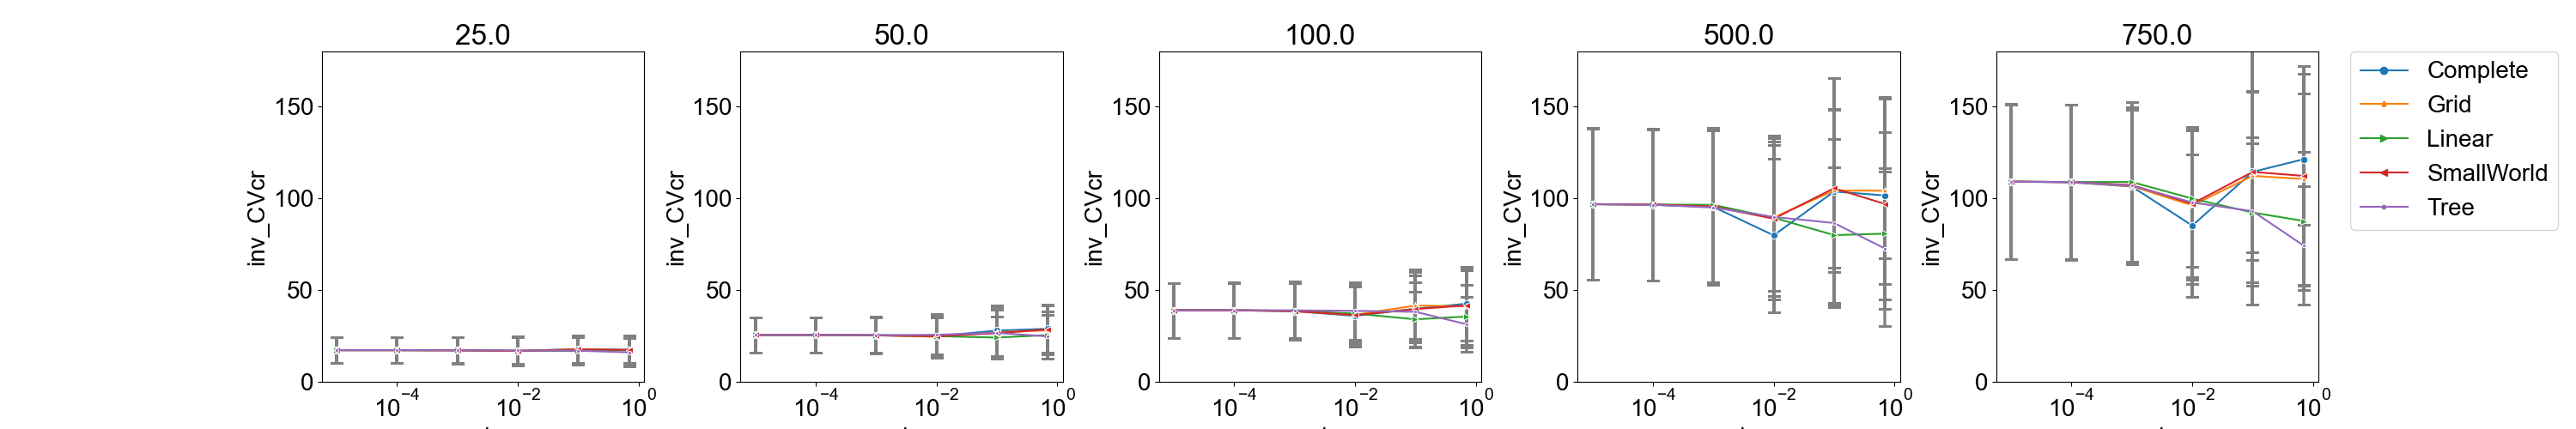

In [23]:
# rho_hetero=0.8, rho_fluc=0.95, std=1, r=0.7, delta=0.001, h=5, C=asymmetric
df25 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N25e25_h5_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N50e50_h5_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N100e100_h5_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N500e500_h5_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Nov-15/Results_WL7-4_5nets_N750e750_h5_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

dfall["inv_CVcr"] = 1 / dfall["CVcr"]

df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)]
regPlots(df,"d","inv_CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=[0,180],fsize=[30,5],logscale=True)

### Figure A2 (top row, r=0.7)

<IPython.core.display.Javascript object>


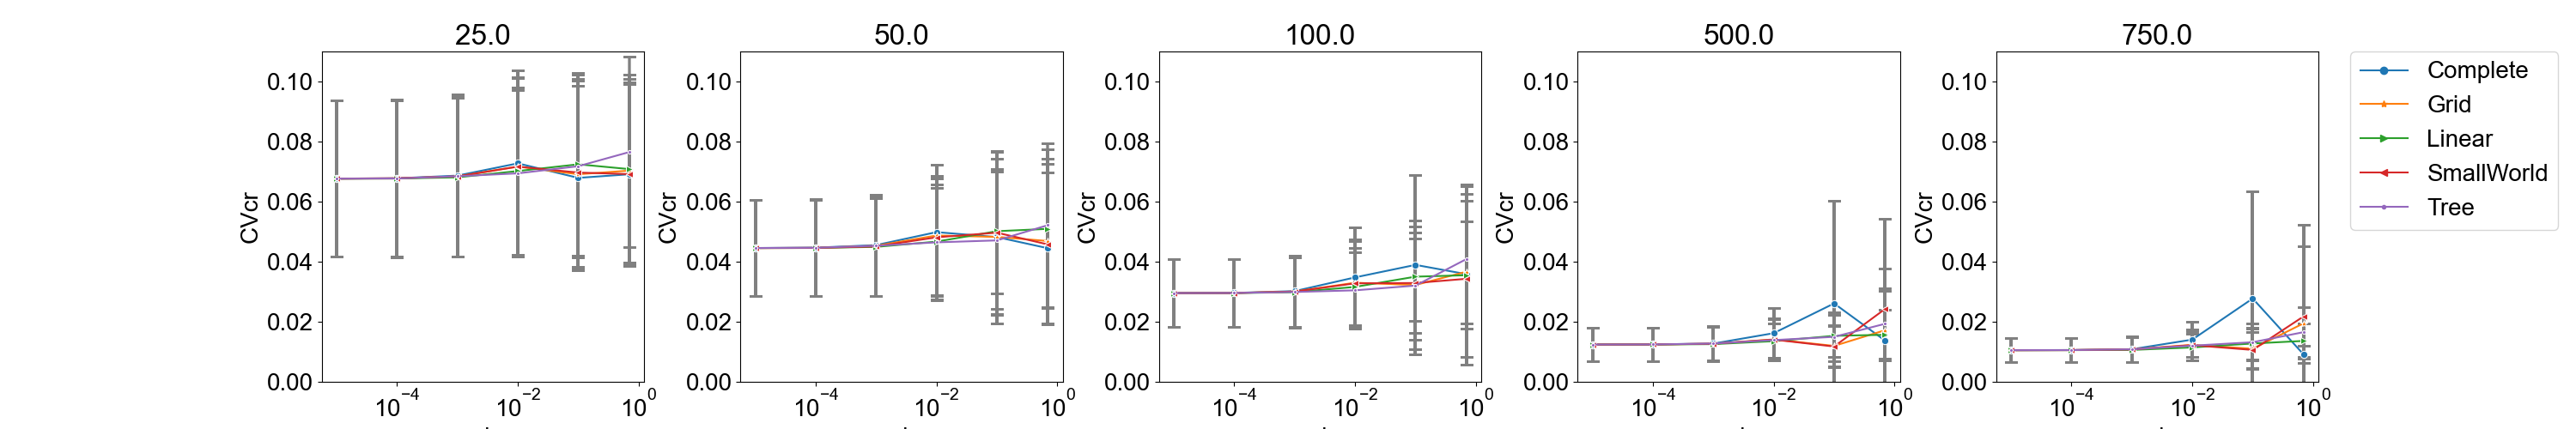

In [24]:
df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)]
regPlots(df,"d","CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=[0,0.11],fsize=[30,5],logscale=True)

### Full model with asymmetric interaction matrix (C)

In [27]:
# [h=5 with standard settings] rho_hetero=0.8, rho_fluc=0.95, std=1, d=0.5, larger r, delta=0.001, h=5, C=asymmetric
df25 = pd.read_table("WL7-4_results_2022-Aug-1/Results_WL7-4_5nets_N25e25_h5_asymmetric_seed0_r1.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Aug-1/Results_WL7-4_5nets_N50e50_h5_asymmetric_seed0_r1.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Aug-1/Results_WL7-4_5nets_N100e100_h5_asymmetric_seed0_r1.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Aug-1/Results_WL7-4_5nets_N500e500_h5_asymmetric_seed0_r1.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Aug-1/Results_WL7-4_5nets_N750e750_h5_asymmetric_seed0_r1.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

dfall["inv_CVcr"] = 1 / dfall["CVcr"]

<IPython.core.display.Javascript object>


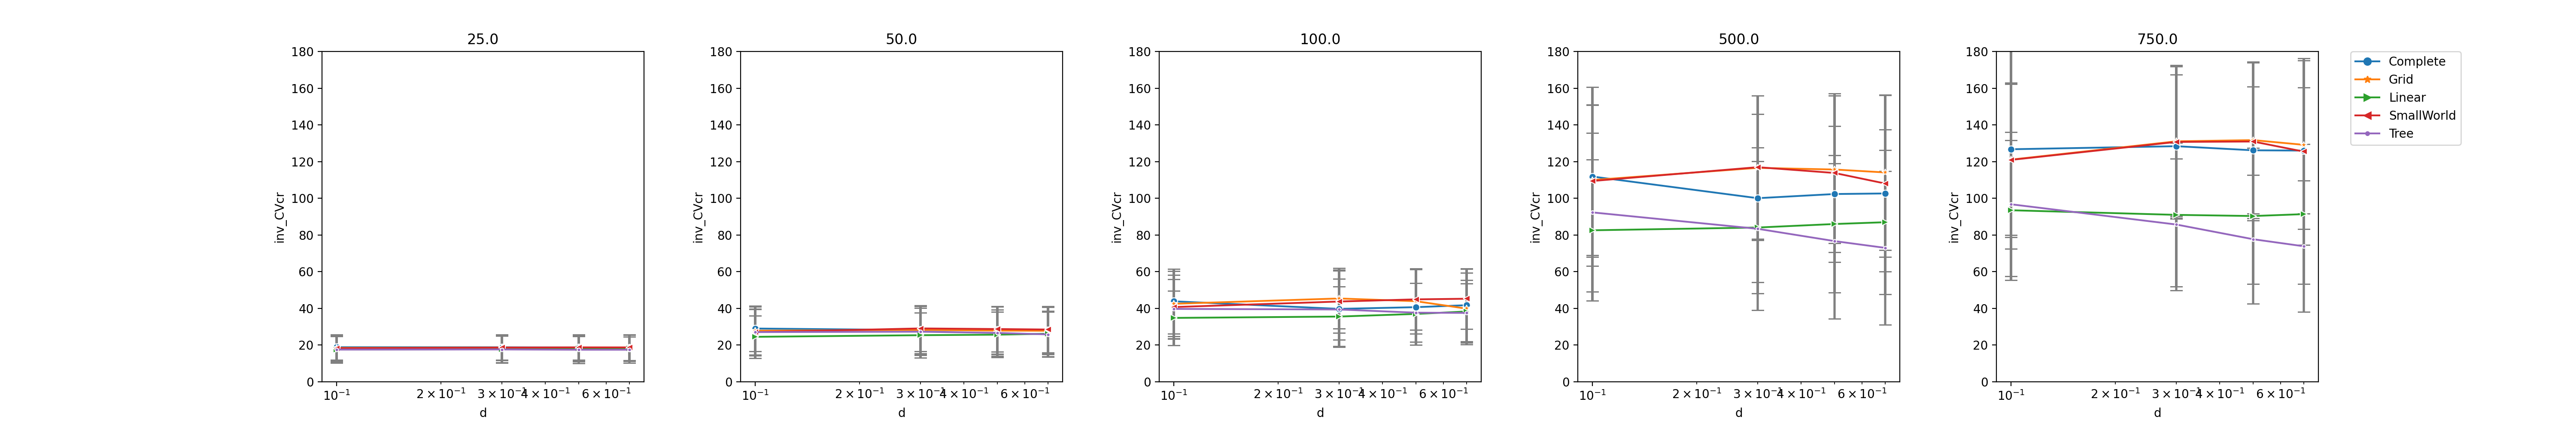

In [28]:
df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)]
regPlots(df,"d","inv_CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=[0,180],fsize=[30,5])
# Figure 2a (N=25) and 2b (N=750)

### h=5, r1

<IPython.core.display.Javascript object>


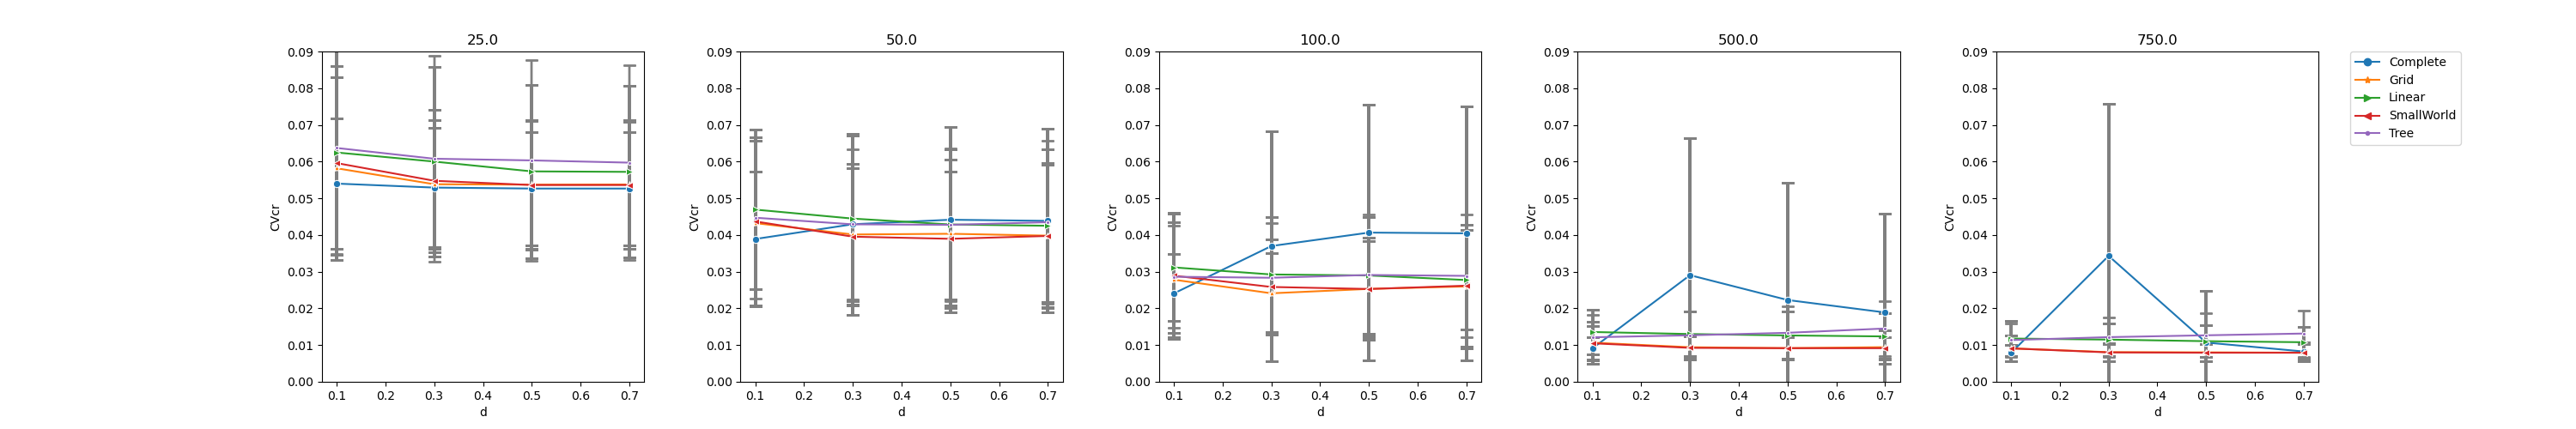

In [10]:
df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)]
regPlots(df,"d","CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=[0,0.09],fsize=[30,5])
# Figure 2a (N=25) and 2b (N=750)

### h=5, r0.7

<IPython.core.display.Javascript object>


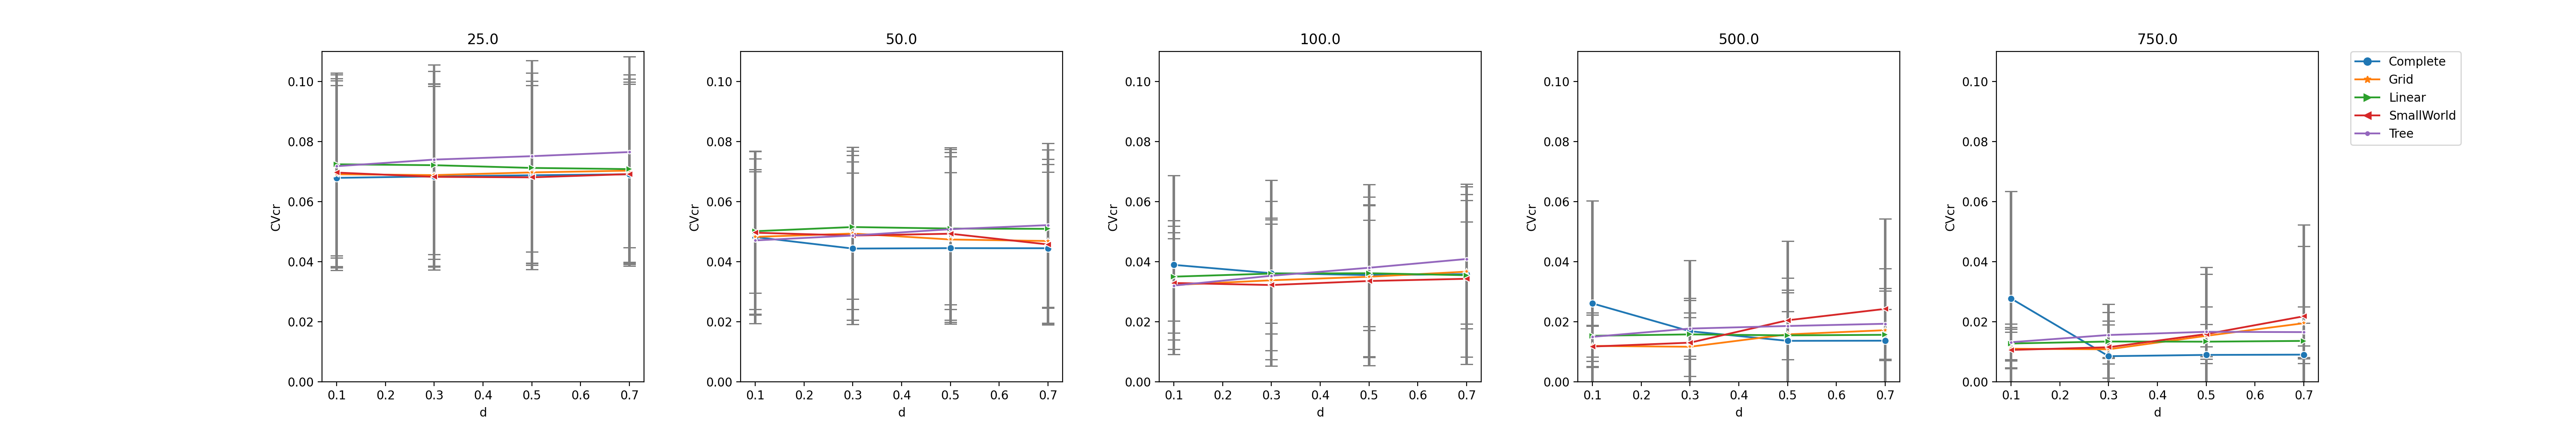

In [31]:
# [h=5 with standard settings] rho_hetero=0.8, rho_fluc=0.95, std=1, d=0.1,0.3,0.5,0.7, r=0.7, delta=0.001, h=5, C=asymmetric
df25 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N25e25_h5_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N50e50_h5_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N100e100_h5_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N500e500_h5_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N750e750_h5_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols
dfall["inv_CVcr"] = 1 / dfall["CVcr"]
df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)]
regPlots(df,"d","CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=[0,0.11],fsize=[30,5])

<IPython.core.display.Javascript object>


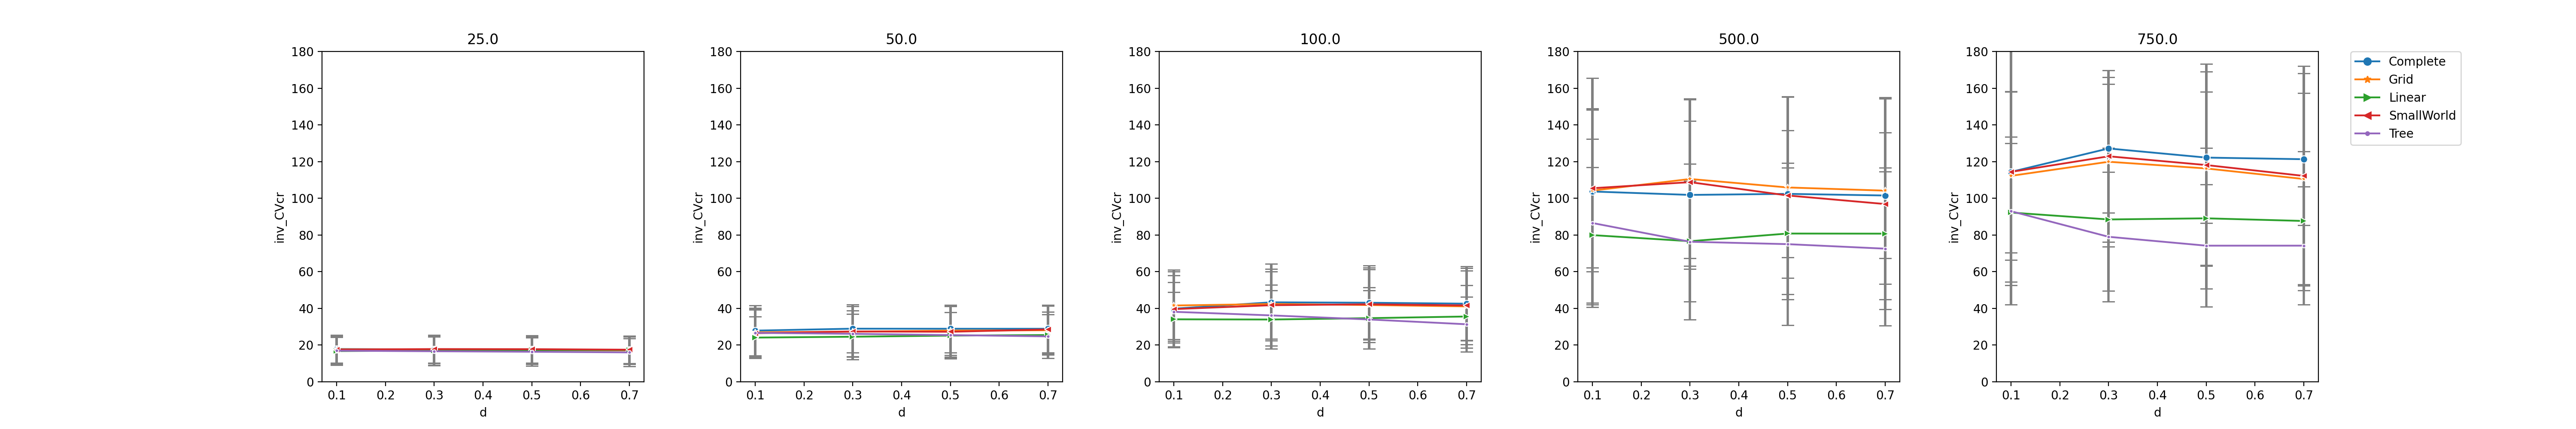

In [34]:
df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)]
regPlots(df,"d","inv_CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=[0,180],fsize=[30,5])

### delta = 0.01,h=0.1,asymmetric (Figure A1(d))

<IPython.core.display.Javascript object>


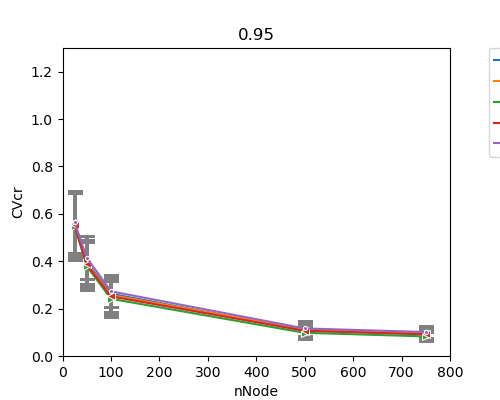

In [13]:
# [delta=0.01 with standard settings] rho_hetero=0.8, rho_fluc=0.95 std=1, d=0.5, r=0.7, delta=0.01, h=0.1, C=asymmetric
df25 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N25e25_h0.1_asymmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N50e50_h0.1_asymmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N100e100_h0.1_asymmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N500e500_h0.1_asymmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N750e750_h0.1_asymmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

df_asym = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df_asym,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3],fsize=[5,4])
# Figure A1(d)

### delta = 0.01,h=0.1,symmetric (Figure A1(p))

<IPython.core.display.Javascript object>


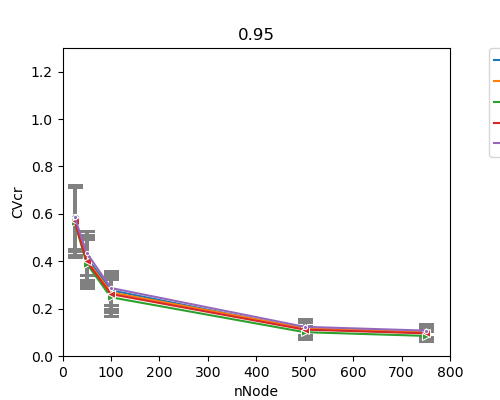

In [15]:
# [delta=0.01 with standard settings] rho_hetero=0.8, rho_fluc=0.95 std=1, d=0.5, r=0.7, delta=0.01, h=0.1, C=symmetric
df25 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N25e25_h0.1_symmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N50e50_h0.1_symmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N100e100_h0.1_symmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N500e500_h0.1_symmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N750e750_h0.1_symmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

df_asym = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df_asym,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3],fsize=[5,4])
# Figure A1(p)

### delta=0.01, h=1,asymmetric (Figure A1(j))

<IPython.core.display.Javascript object>


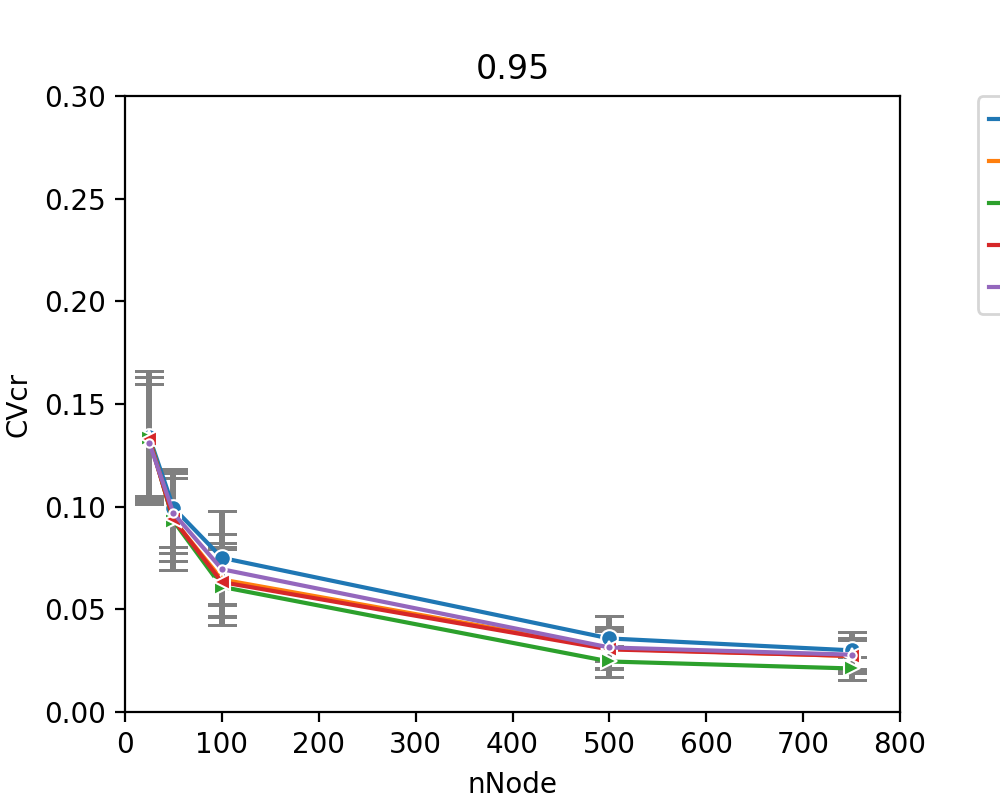

In [6]:
# [delta=0.01 with standard settings] rho_hetero=0.8, rho_fluc=0.95 std=1, d=0.5, r=0.7, delta=0.01, h=1, C=asymmetric
df25 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N25e25_h1_asymmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N50e50_h1_asymmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N100e100_h1_asymmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N500e500_h1_asymmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N750e750_h1_asymmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

df_asym = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df_asym,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,0.3],fsize=[5,4])
# Figure A1(j)

### delta=0.01, h=1,symmetric (Figure A1(v))

<IPython.core.display.Javascript object>


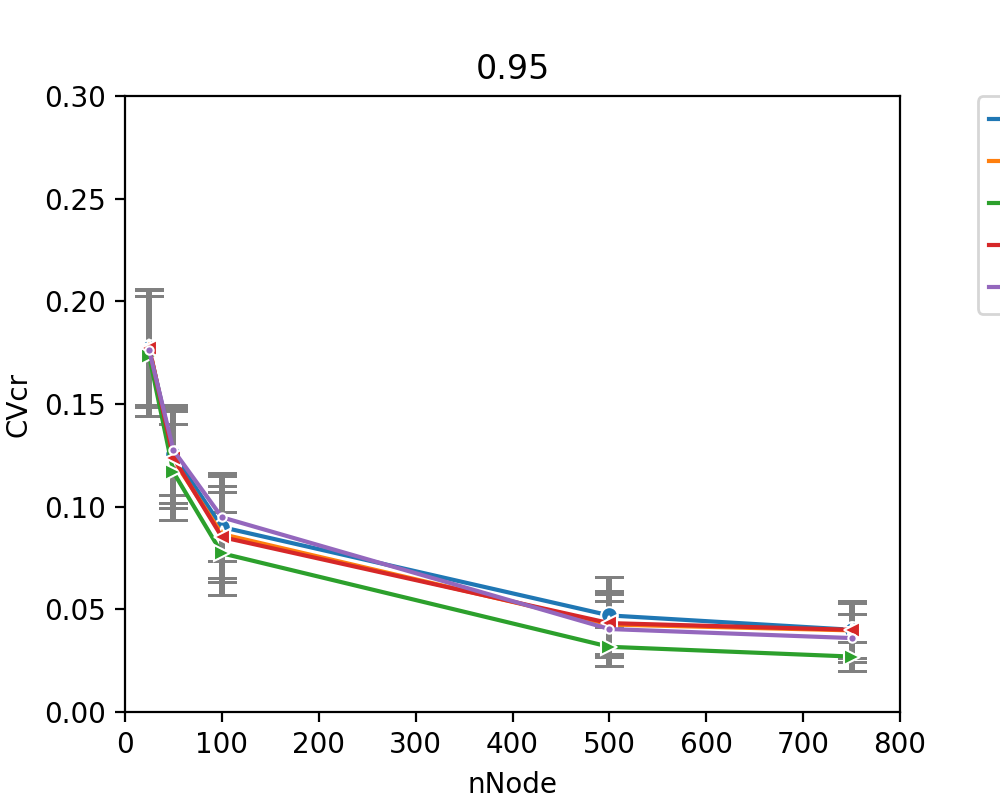

In [7]:
# [delta=0.01 with standard settings] rho_hetero=0.8, rho_fluc=0.95 std=1, d=0.5, r=0.7, delta=0.01, h=1, C=symmetric
df25 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N25e25_h1_symmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N50e50_h1_symmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N100e100_h1_symmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N500e500_h1_symmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N750e750_h1_symmetric_seed0_r0.7_delta0.01.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

df_asym = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df_asym,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,0.3],fsize=[5,4])
# Figure A1(v)

### rho_fluc = 0.5, h=0.1, asymmetric (Figure A1(e))

<IPython.core.display.Javascript object>


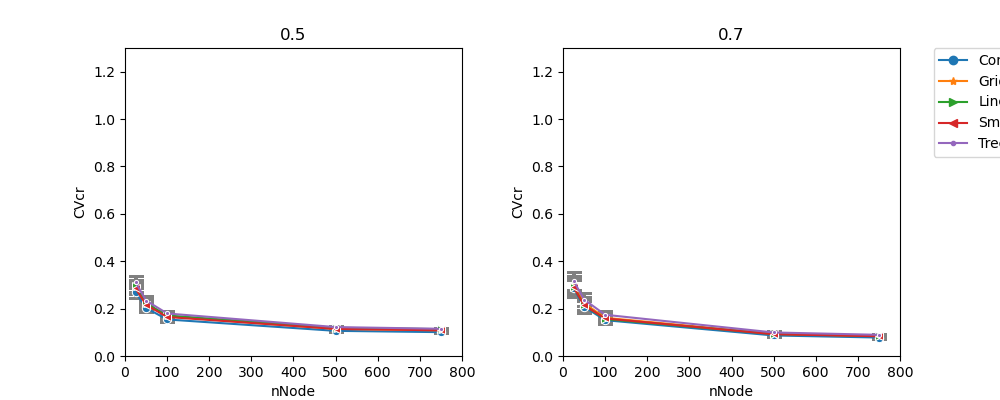

In [19]:
# [rho_fluc=0.5/0.7 with standard settings] rho_hetero=0.8, rho_fluc=0.5, std=1, d=0.5, r=0.7, delta=0.001, h=0.1, C=asymmetric
df25 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N25e25_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N50e50_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N100e100_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N500e500_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N750e750_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

df_asym = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df_asym,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3],fsize=[10,4])
# left: Figure A1(e)

### rho_fluc = 0.5, h=0.1, symmetric (Figure A1(q))

<IPython.core.display.Javascript object>


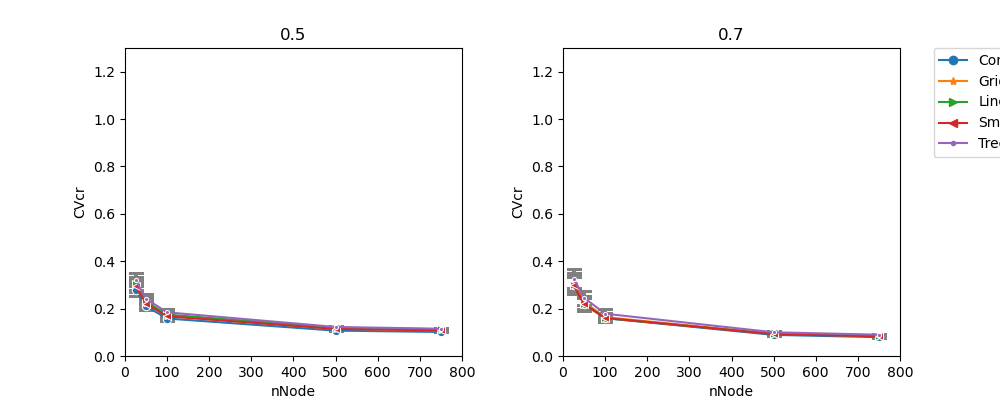

In [20]:
# [rho_fluc=0.5/0.7 with standard settings] rho_hetero=0.8, rho_fluc=0.5, std=1, d=0.5, r=0.7, delta=0.001, h=0.1, C=symmetric
df25 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N25e25_h0.1_symmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N50e50_h0.1_symmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N100e100_h0.1_symmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N500e500_h0.1_symmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N750e750_h0.1_symmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

df_asym = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df_asym,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3],fsize=[10,4])
# left: Figure A1(q)

### rho_fluc = 0.5, h=1,asymmetric (Figure A1(k))

<IPython.core.display.Javascript object>


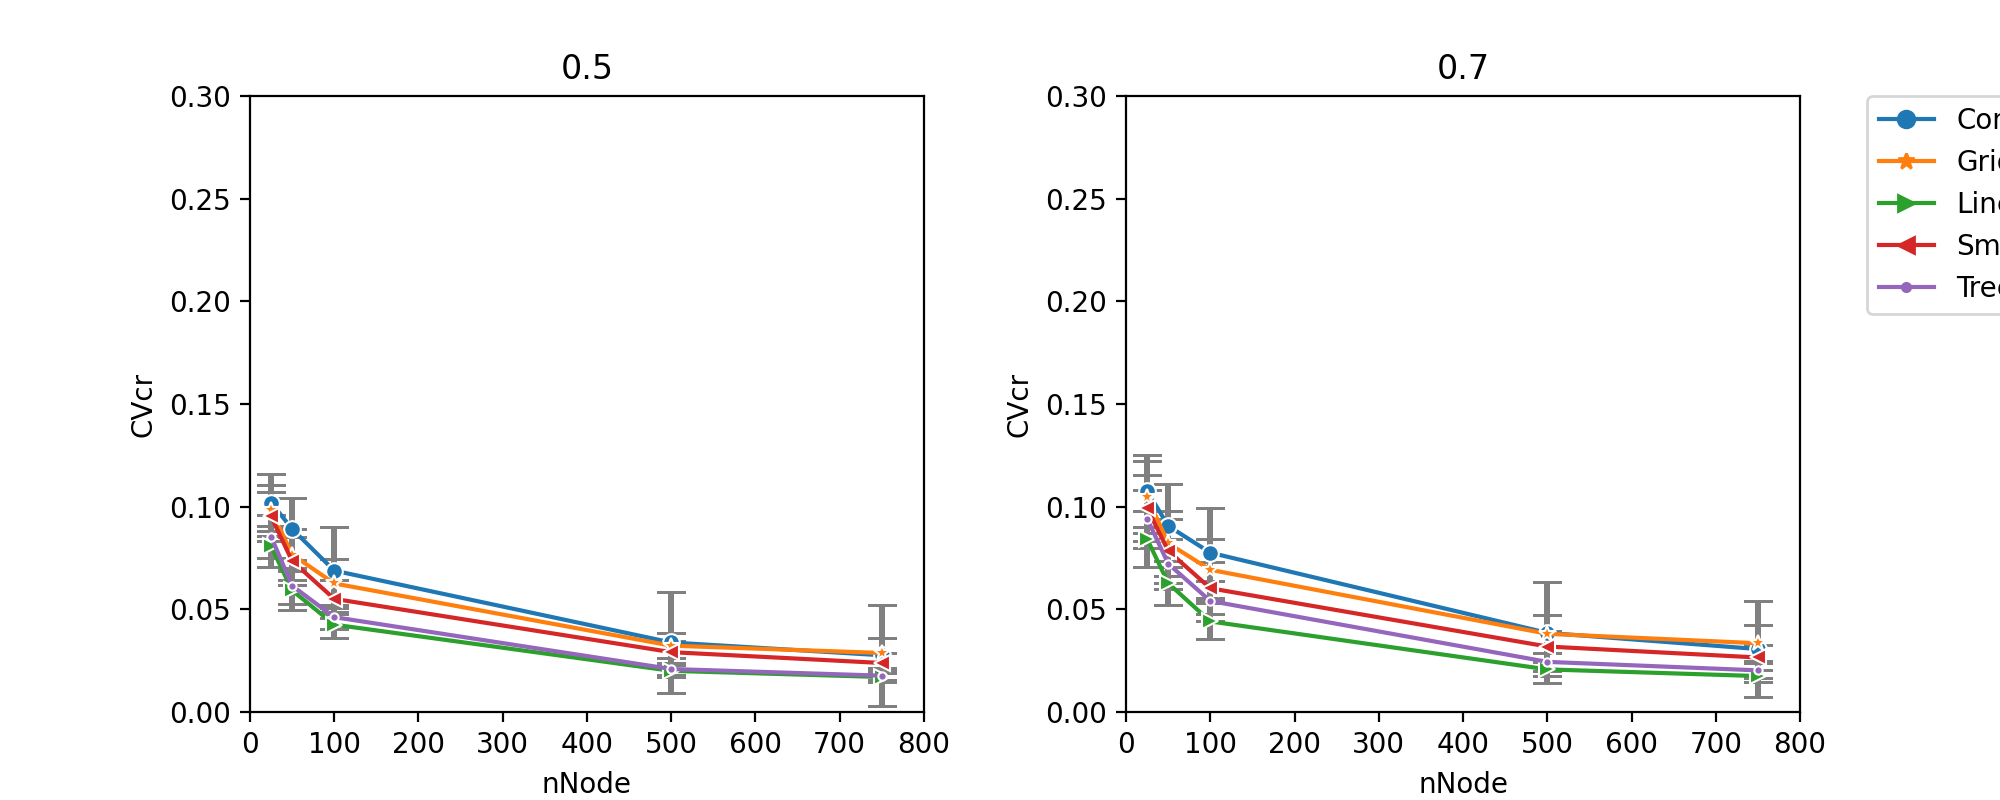

In [9]:
# [rho_fluc=0.5/0.7 with standard settings] rho_hetero=0.8, rho_fluc=0.5, std=1, d=0.5, r=0.7, delta=0.001, h=1, C=asymmetric
df25 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N25e25_h1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N50e50_h1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N100e100_h1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N500e500_h1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N750e750_h1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

df_asym = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df_asym,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,0.3],fsize=[10,4])
# left: Figure A1(k)

### rho_fluc = 0.5, h=1,symmetric (Figure A1(w))

<IPython.core.display.Javascript object>


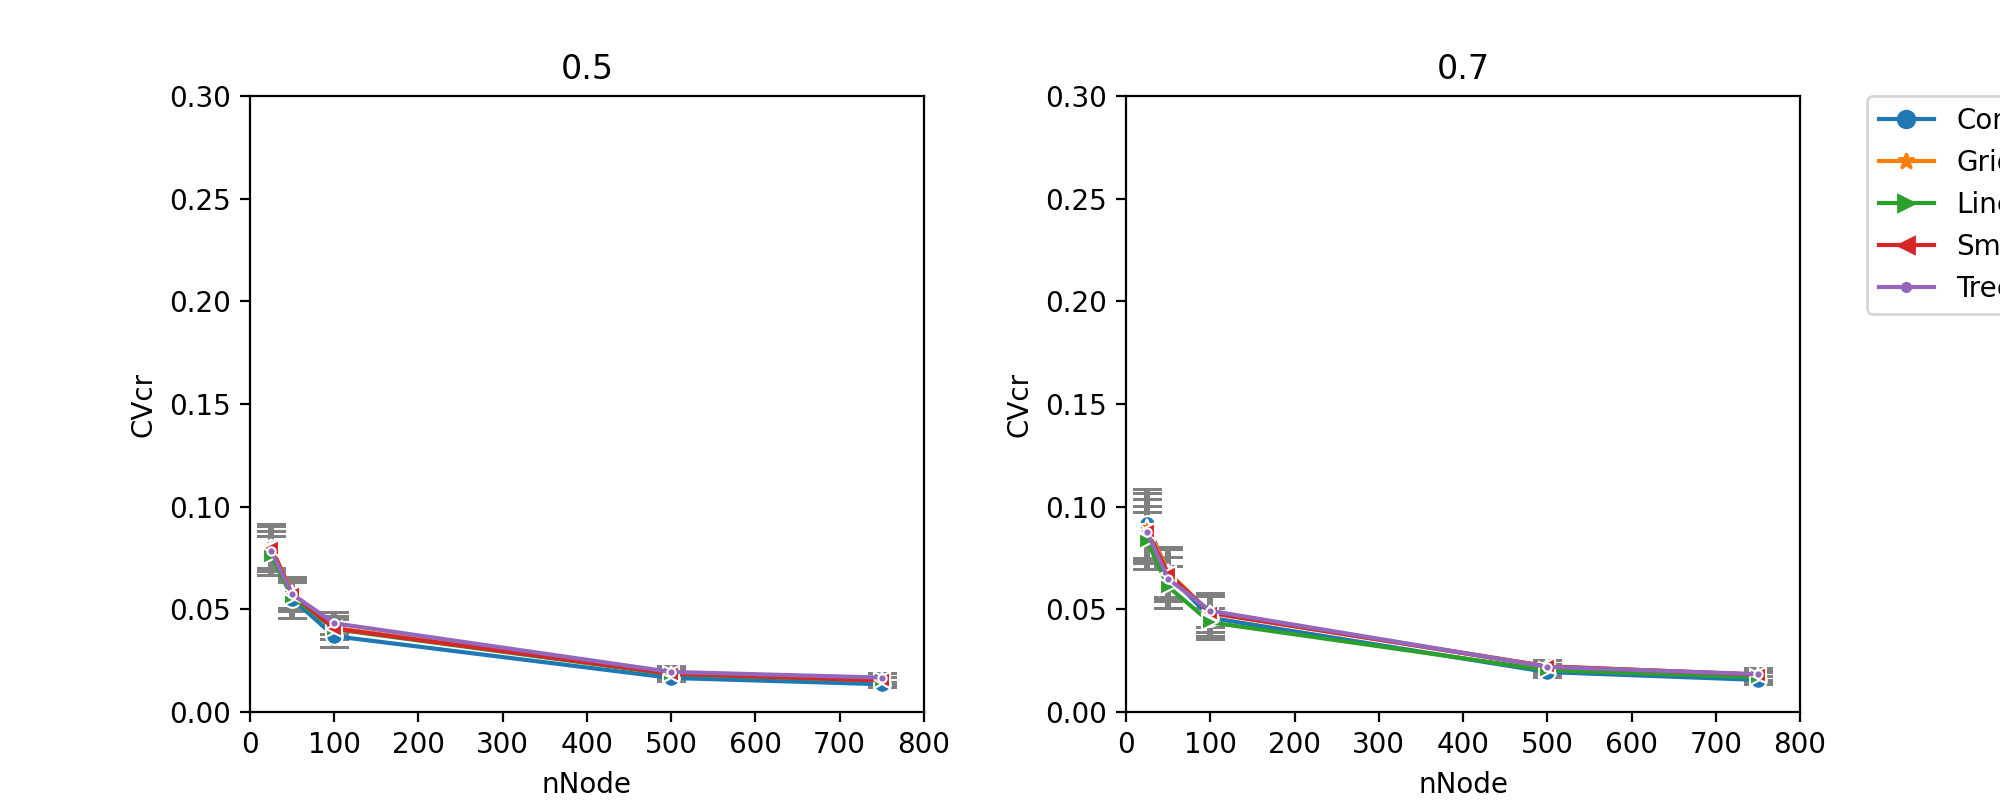

In [9]:
# [rho_fluc=0.5/0.7 with standard settings] rho_hetero=0.8, rho_fluc=0.5, std=1, d=0.5, r=0.7, delta=0.001, h=1, C=symmetric
df25 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N25e25_h1_symmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N50e50_h1_symmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N100e100_h1_symmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N500e500_h1_symmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N750e750_h1_symmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

df_asym = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df_asym,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,0.3],fsize=[10,4])
# left: Figure A1(w)

### Figure 4(a),(d): synchrony with rho_fluc = 0.5

<IPython.core.display.Javascript object>


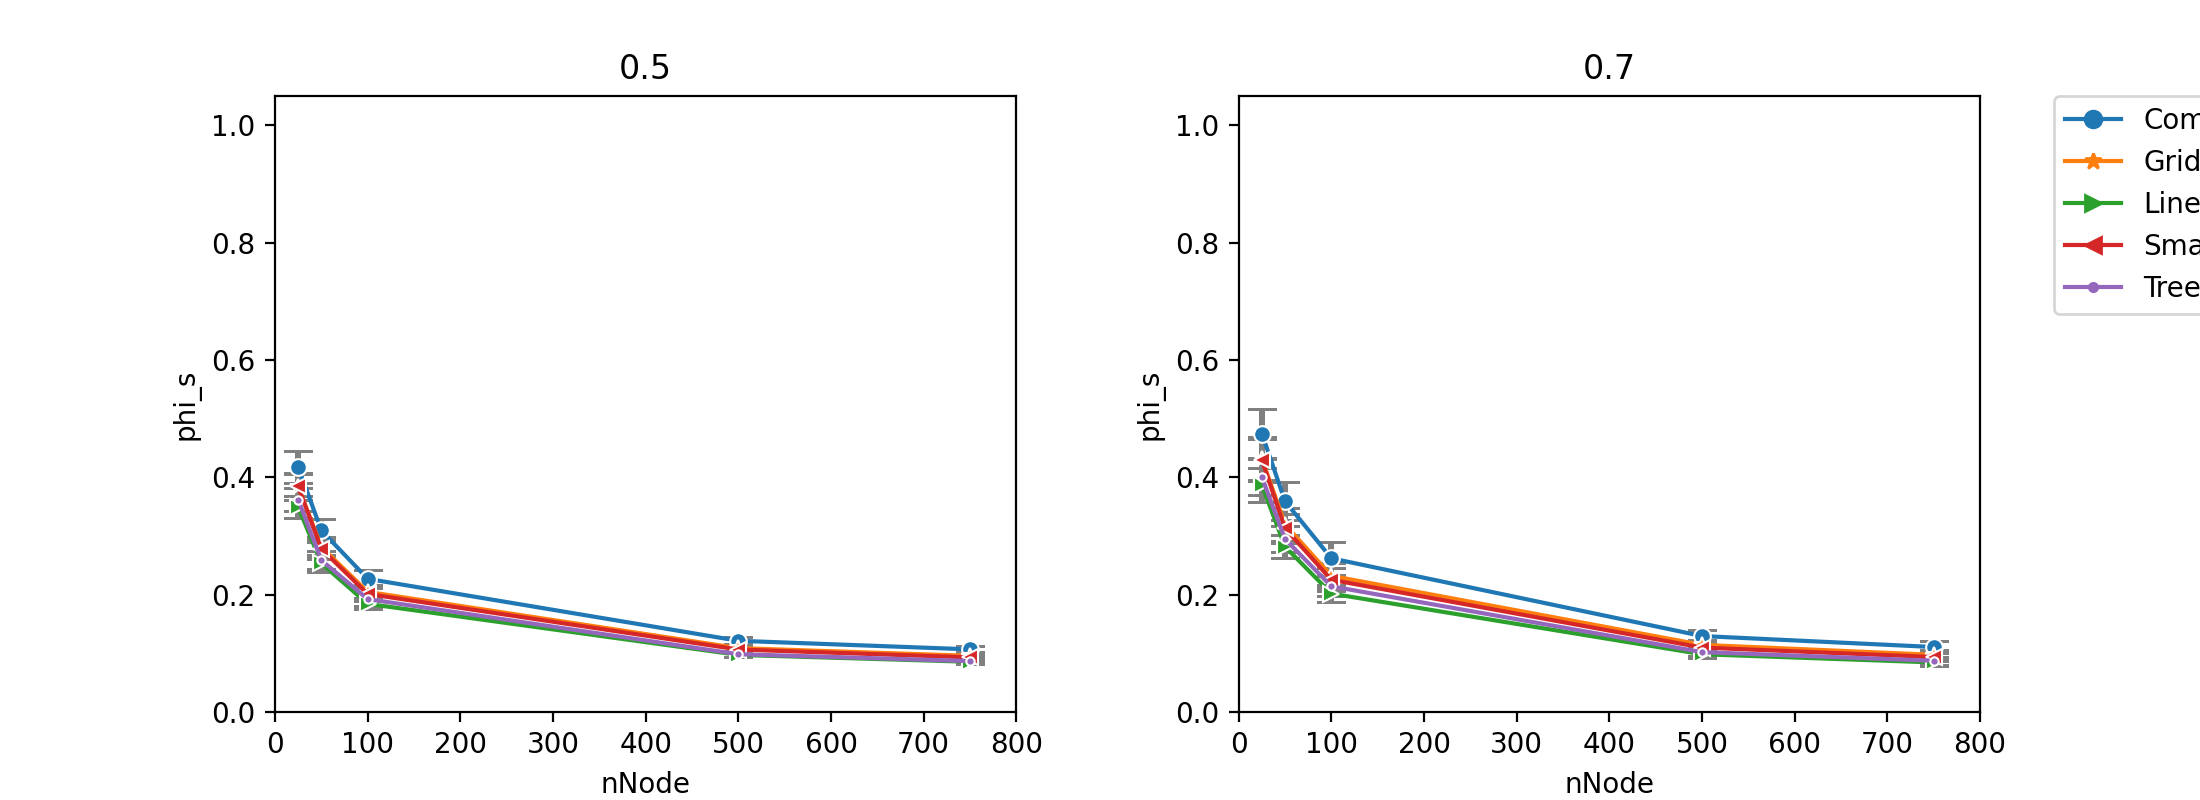

In [12]:
# [rho_fluc=0.5/0.7 with standard settings] rho_hetero=0.8, rho_fluc=0.5, std=1, d=0.5, r=0.7, delta=0.001, h=0.1, C=asymmetric
df25 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N25e25_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N50e50_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N100e100_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N500e500_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N750e750_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df,"nNode","phi_s","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.05],fsize=[11,4])
# Left: Figure 4a

<IPython.core.display.Javascript object>


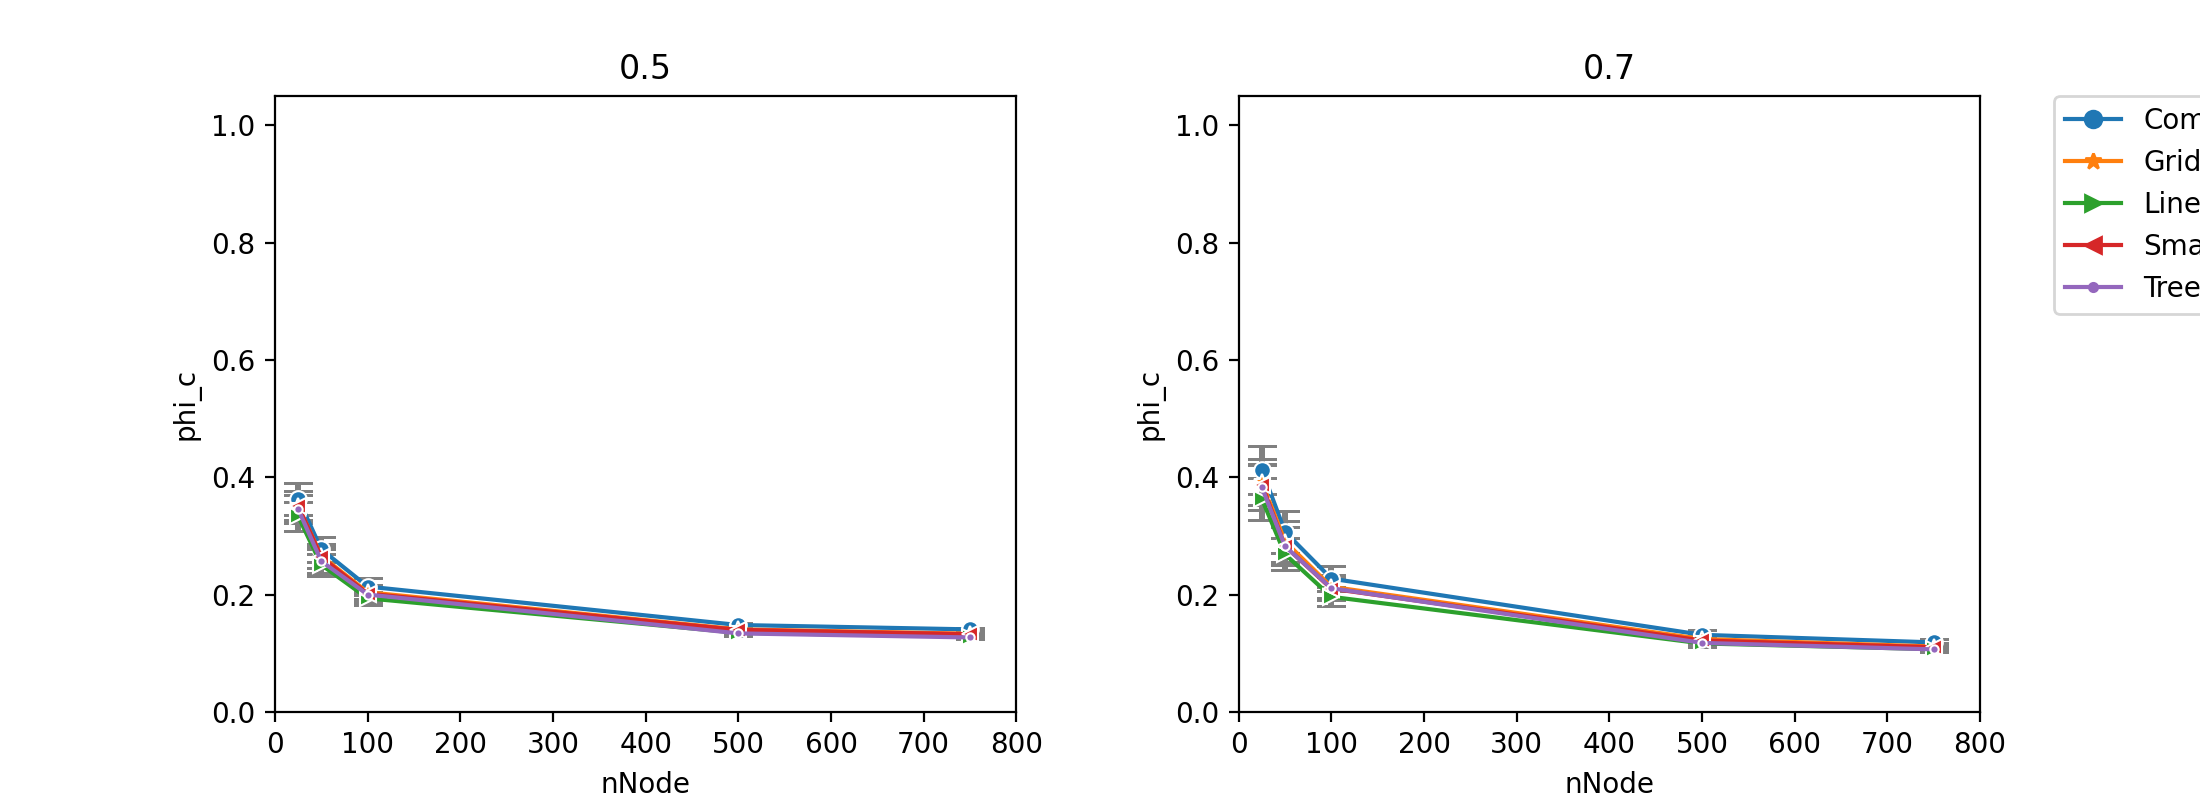

In [13]:
df25 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N25e25_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N50e50_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N100e100_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N500e500_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_2022-Sep-26/Results_WL7-4_5nets_N750e750_h0.1_asymmetric_seed0_r0.7_delta0.001.txt",delim_whitespace=True)
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df,"nNode","phi_c","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.05],fsize=[11,4])
# left: Figure 4d